In [1]:
# Method for pre-processing x-ray images and generating knee joint dataset

%matplotlib inline

import random as rand
#import pandas as pd
import numpy as np
#from PIL import Image
#import dicom
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

# Functions to Preprocess Images

In [2]:
# Methods for preprocessing the images 
# Changes resolution, rescales pixel values, changes MONOCHROME1, crops approximate knee joint areas

'''
    Def:
        Interpolate image to get a fixed resolution - we use a scaling factor of 0.2
    Params:
        image_dicom = dicom of xray images
        scaling_factor = factor to scale resolution
    Return:
        image_array = array for image with scaled resolution
'''
def interpolate_resolution(image_dicom, scaling_factor):
    
    image_array = image_dicom.pixel_array
    
    x = image_dicom[0x28, 0x30].value[0]
    y = image_dicom[0x28, 0x30].value[1]
    
    image_array = ndimage.zoom(image_array, [x/scaling_factor, y/scaling_factor])
    return image_array


'''
    Def:
        Function for re-scaling images that have (0028, 1050) and (0028, 1051) dicom headers
        Re-scale the pixel values using 
        Method from ftp://dicom.nema.org/MEDICAL/dicom/2014c/output/chtml/part03/sect_C.11.2.html#sect_C.11.2.1.2)
    Params:
        image_dicom = dicom of xray images
        image_array = array for an image
    Return:
        image_array = array for image that has pixel values rescaled using a different method
'''
def scale_pixel_values_using_cw(image_dicom, image_array):
    
    c = image_dicom[0x28, 0x1050].value
    w = image_dicom[0x28, 0x1051].value
    
    image_array = np.where(image_array <= (c - 0.5 - (w-1)/2), 0,  
                           np.where(image_array > c - 0.5 + (w-1)/2, 255.0, 
                                    np.float32(((image_array - (c-0.5))/(w-1) + 0.5) * 255.0 )))
    return image_array


'''
    Def:
        Function for re-scaling images that have type LOG_E REL for header (0028, 1054)
    Params:
        image_dicom = dicom of xray images
        image_array = array for an image
    Return:
        image_array = array for image that has pixel values rescaled using a logerel method
'''
def scale_pixel_values_using_logerel(image_dicom, image_array):
    
    intercept = image_dicom[0x28, 0x1052].value
    slope = image_dicom[0x28, 0x1053].value
    
    # For edge cases w/o intercept or slope values, then we will force the use of intercept = 0.0, slope = 1.0
    if isinstance(intercept, str):
        intercept = 0.0
        slope = 1.0
        print(image_dicom[0x10, 0x20].value + ' is an edge  case for pixel scaling')
    
    # Linear transformation of data w/ slope and intercept values
    image_array = slope * image_array + intercept
    
    minimum = np.min(image_array)
    maximum = np.max(image_array)
    
    # Re-scale to new range of 0-255
    image_array = np.float32(255.0 * (image_array - minimum) / (maximum - minimum))
    return image_array


'''
    Def:
        Function for inverting images with MONOCHROME1 after the images have been converted to same pixel scale
    Params:
        image_array = array for an image
    Return:
        image_array = image with monochrome1 inverted
'''
def invert_Monochrome1(image_array):
    image_array = -image_array + 255.0
    return image_array


'''
    Def:
        Method to automatically extract knee joint
        For parameter side: 1 = right, 0 = left
    Params:
        image_array = array for an image
        side = side of knee
    Return:
        image_array = cropped knee joint array
'''
def extract_knee(image_array, side):
    
    print('Dimensions of image: ', image_array.shape)
    
    # Compute the sum of each row and column
    col_sums = np.sum(image_array, axis = 0)
    row_sums = np.sum(image_array, axis = 1)
    
    # Row index for cropping is centered at the minimum of the row_sums array
    row_start = np.argmin(row_sums)-512
    row_end = np.argmin(row_sums)+512
    print('Row Indices Original: ', row_start, row_end)
    
    # However, if either the start or end of the row values is beyond the original image array shape
    # We center the cropped image at the center row of the original image array
    if row_start < 0 or row_end > (image_array.shape[0]-1):
            row_start = round(image_array.shape[0]/2)-512
            row_end = round(image_array.shape[0]/2)+512
            
    print('Row Indices Final: ', row_start, row_end)
    
    # For right knee, crop columns to be centered at the maximum sum of the LHS of original image array 
    # Shift over by 500 columns in edge cases with white outer bars   
    if side == 1:
        col_center = 500+np.argmax(col_sums[500:round(col_sums.shape[0]/2)])
        print('Column Indices for Right Original: ', col_center-512, col_center+512)
        
        # If column is below original image array size, then start cropping on left hand border and go out 1024 columns
        if (col_center - 512) < 0:
            print('Column Indices for Right Final: ', 0, 1024)
            image_array = image_array[row_start:row_end, :1024]           
            
        else:
            image_array = image_array[row_start:row_end, (col_center-512):(col_center+512)]
            print('Column Indices for Right Final: ', col_center-512, col_center+512)
            
    # For left knee, crop columns to be centered at the maximum sum of the RHS of original image array 
    # Shift over by 500 columns in edge cases with white outer bars
    if side == 0:
        col_center = round(col_sums.shape[0]/2)+np.argmax(col_sums[round(col_sums.shape[0]/2):col_sums.shape[0]-500])
        print('Column Indices for Left Original: ', col_center-512, col_center+512)
       
        # If column is above original image array size, then start cropping on right hand border and go in 1024 columns
        if (col_center + 512) > (image_array.shape[1]-1):
            print('Column Indices for Left Final: ', image_array.shape[1]-1024, image_array.shape[1]-1)
            image_array = image_array[row_start:row_end, image_array.shape[1]-1024:]
            
        else:
            image_array = image_array[row_start:row_end, (col_center-512):(col_center+512)]
            print('Column Indices for Left Final: ', col_center-512, col_center+512)
    return image_array


'''
    Def:
        Take right or left side of image - does not crop 1024x1024 sized images but just slices the image into right / left halves
        1 = right, 0 = left
    Params:
        image_array = array for an image
        side = right or left
    Returns:
        image_array = cropped right / left side of knee xray
'''
def take_side(image_array, side):
    
    if side == 1:
        image_array = image_array[:, :round(image_array.shape[1]/2)]
        
    if side == 0:
        image_array = image_array[:, round(image_array.shape[1]/2):]
        
    return image_array


'''
    Def:
        Method for pre-processing the images, which combines the above methods
        1. Re-scale image depending on what DICOM header information is available
        2. If image is MONOCHROME1 - invert to MONOCHROME2 scale
        3. Interpolate image with a new pixel scaling factor of: (from DICOM) original-pixel-width / 0.2
    Params:
        image_dicom = dicom of image (information with image array)
    Return:
        image_array = preprocessed image
'''
def augment_xrays(image_dicom):
    
    image_array = interpolate_resolution(image_dicom, 0.2)
    
    if (0x28, 0x1050) in image_dicom and (0x28, 0x1051) in image_dicom:
        image_array = scale_pixel_values_using_cw(image_dicom, image_array)
        print('Scaled with 28, 1050 and 28, 1051 method')
    
    else: 
        image_array = scale_pixel_values_using_logerel(image_dicom, image_array)
        print('Scaled with Linear Transform')
        
    if image_dicom[0x28, 0x04].value == "MONOCHROME1":
        image_array = invert_Monochrome1(image_array)
        print(image_dicom[0x10, 0x20].value, image_dicom[0x28, 0x04].value)
        
    return image_array 


'''
    Def:
        Writes the image to disk (from Cem)
    Params:
        img = the rgb image to save
        path = the target path
'''
def save_image(img, path):
    
    Image.fromarray(img.round().astype(np.uint8)).save(path, 'jpeg', dpi=[300, 300], quality=90)


'''
    Def:
        Converts the given array into a RGB image. If the number of channels is not
        3 the array is tiled such that it has 3 channels
    Params:
        img = the array to convert [nx, ny, channels]
    Return:
        img = the rgb image [nx, ny, 3]
'''
def to_rgb(img):
   
    img = np.atleast_3d(img)
    channels = img.shape[2]
    if channels < 3:
        img = np.tile(img, 3)
    return img


'''
    Def:
        Given a data frame of image id and side, preprocesses images (rescale, invert, interpolate, crop)
        Other params denote which images we want (which visit (list of strings) and which cohort (a single string)) 
    Params:
        data = list of IDs
        months = list of months id
        cohort = name of cohort
    Return:
        final_array_1024 = list with 2 arrays:
                                1. patient information with id, label, side
                                2. image pixels
'''
def fully_preprocess_xrays(data, months, cohort):
    
    # Create 2 Numpy arrays - one to encode patient information and the others to store the images (1024 and 224 scales)
    # For array of patient information: 
    # 1st column = id, 2nd column = indicator for TKR (1) or no TKR (0), 3rd column = side - right (1) or left (0)
    array_of_information = np.array(data.iloc[:,[1,6,7]])
    array_of_images_1024 = np.empty([len(data), 1024, 1024], dtype=np.float32)
    
    # Iterate over the list of month codes
    for j in months:
        for i in range(len(data)):
            # path where DICOM images are stored
            path = 'R:\\denizlab\\denizlabspace\\Users\\Kevin_Leung\\2017-07-26 Kevin\\' + cohort + ' raw\\' + str(data.iloc[i,1]) + '\\xray\\' + j
            print(i, path)
            image_dicom = dicom.read_file(path)
            
            # Entire image preprocessing procedure
            image_array = augment_xrays(image_dicom)
            image_array_1024 = extract_knee(image_array, data.iloc[i,7])
            print('Min and Max of Full Image:    ', np.min(image_array), np.max(image_array))
            print('Min and Max of Cropped Image: ', np.min(image_array_1024), np.max(image_array_1024))
            print()
            
            # Store the arrays in corresponding parent arrays
            array_of_images_1024[i,:,:] = image_array_1024
            
            # Paths to save jpegs for images
            preprocessed_image_file = str(data.iloc[i,1]) + '_label_' + str(data.iloc[i,6]) + '_side_' + str(data.iloc[i,7]) + '_month_' + j +'.jpeg'  
            preprocessed_path_1024 = 'R:\\denizlab\\denizlabspace\\Users\\Kevin_Leung\\2017-07-26 Kevin\\' + cohort + ' preprocessed\\jpegs_of_preprocessed_knees_1024x1024\\' + preprocessed_image_file  
            
            # First convert to rgb for jpeg format then save in the above path
            image_to_save_1024 = to_rgb(image_array_1024)
            save_image(image_to_save_1024, preprocessed_path_1024)
                    
    # Final array to return combines the numpy array for patient information and the preprocessed image arrays                
    final_array_1024 = [array_of_information, array_of_images_1024]
    return final_array_1024  

In [3]:
# Methods for randomly separating 1024x1024 images into train, validation, and test sets

'''
    Def:
        Randomize original datasets
    Params:
        patient_info = array of patient information with id, label, side
        images = array of images
        dim_1 = size of first dimension
        dim_2 = size of second dimension
    Return:
        randomized_patient_info = patient information array that is randomly scrambled
        randomized_images = patient images that are randomly scrambled
'''
def randomized_data(patient_info, images, dim_1, dim_2):
    
    randomized_indices = rand.sample(range(728), 728)
    randomized_patient_info = np.zeros([728,3])
    randomized_images = np.zeros([728, dim_1, dim_2])
    
    for i in range(728):
        randomized_patient_info[i] = patient_info[randomized_indices[i]]
        randomized_images[i] = images[randomized_indices[i]]
        
    return randomized_patient_info, randomized_images


'''
    Def:
        Separate data set into training, validation, and test sets
        First randomly shuffle vector of 0-727 which will be used as the indices for our respective datasets
    Params:
        patient_info = array of patient information with id, label, side
        images = array of images
        dim_1 = size of first dimension
        dim_2 = size of second dimension
    Return:
        training_data = training set after scrambled
        validation_data = validation set after scrambled
        test_data = test set after scrambled
'''
def separate_sets_v2(patient_info, images, dim_1, dim_2):
    
    randomized_patient_info, randomized_images = randomized_data(patient_info, images, dim_1, dim_2)
    
    training_patient_info = np.zeros([510, 3])
    validation_patient_info = np.zeros([74, 3])
    test_patient_info = np.zeros([144, 3])
    
    training_images = np.zeros([510, dim_1, dim_2])
    validation_images = np.zeros([74, dim_1, dim_2])
    test_images = np.zeros([144, dim_1, dim_2])
    
    j = 0
    k = 0
    l = 0

    for i in range(728):
        if randomized_patient_info[i,1] == 1:
            if np.sum(training_patient_info[:,1]) < 255:
                training_patient_info[j] = randomized_patient_info[i]
                training_images[j] = randomized_images[i]
                j += 1
            
            elif np.sum(validation_patient_info[:,1]) < 37:
                validation_patient_info[k] = randomized_patient_info[i]
                validation_images[k] = randomized_images[i] 
                k += 1
            
            elif np.sum(test_patient_info[:,1]) < 72:
                test_patient_info[l] = randomized_patient_info[i]
                test_images[l] = randomized_images[i]
                l += 1
                
        elif randomized_patient_info[i,1] == 0:
            if j - np.sum(training_patient_info[:,1]) < 255:
                training_patient_info[j] = randomized_patient_info[i]
                training_images[j] = randomized_images[i]
                j += 1
            
            elif k - np.sum(validation_patient_info[:,1]) < 37:
                validation_patient_info[k] = randomized_patient_info[i]
                validation_images[k] = randomized_images[i] 
                k += 1
            
            elif l - np.sum(test_patient_info[:,1]) < 72:
                test_patient_info[l] = randomized_patient_info[i]
                test_images[l] = randomized_images[i]
                l += 1
                
    training_data = [training_patient_info, training_images]
    validation_data = [validation_patient_info, validation_images]
    test_data = [test_patient_info, test_images]
        
    return training_data, validation_data, test_data

In [4]:
'''
    Def:
        Re-scale images to 224x224 from 1024x1024 in order to transfer learn from ResNet
        Due to the interpolation, ranges can now be outside of 0-255, 
        so any negative values are pulled to 0 and anything over 255 is forced to 255 
    Params:
        all_images = array of all images
        cohort = name of cohort
        dim1 = size of dimension 1
        dim2 = size of dimension 2
        dim3 = size of dimension 3
    Return:
        final_array_224 = images resized to 224x224
'''
def rescale_to_224_original(all_images, cohort, dim1, dim2, dim3): 
    
    array_of_images_224 = np.empty([all_images[1].shape[0],  dim1, dim2, dim3], dtype=np.float32)
    
    for i in range(all_images[1].shape[0]):
        preprocessed_image_file = str(all_images[0][i,0]) + '_label_' + str(all_images[0][i,1]) + '_side_' + str(all_images[0][i,2]) + '_month_00' +'.jpeg'  
        preprocessed_path_224 = 'R:\\denizlab\\denizlabspace\\Datasets\\OAI\\2017-07-26 Kevin\\' + cohort + ' preprocessed\\jpegs_of_preprocessed_knees_224x224\\' + preprocessed_image_file
        
        image_array_224 = ndimage.zoom(all_images[1][i,:,:], [dim1/1024.0, dim2/1024.0])
        print(i, all_images[0][i,0], "Original Range:", np.min(image_array_224), np.max(image_array_224))
        
        image_array_224 = np.abs(np.where(image_array_224 < 0, 0.0,  
                                          np.where(image_array_224 > 255.0, 255.0, image_array_224)))
        print(i, all_images[0][i,0], "Re-Scaled Range:", np.min(image_array_224), np.max(image_array_224))
        print()
        
        # Images are converted to have 3-color channels (done by just stacking the single array 3 times)
        image_array_224 = to_rgb(image_array_224)
        array_of_images_224[i] = image_array_224    
        save_image(image_array_224, preprocessed_path_224)
        
    final_array_224 = [all_images[0], array_of_images_224]
    return final_array_224

# Pre-processing X-Rays

In [ ]:
IMAGE_IDS = pd.read_csv('H:\\Personal\\Radiology Research\\TKR Deep Learning\\Matched Pairs\\Cohort 2 - All Samples (with KL) - TKR v. no TKR\\list_of_image_ids.csv')

In [6]:
# Code to run in order to preprocess images to a size of 1024x1024 and then save as npz file types
cohort2_1024x1024 = fully_preprocess_xrays(IMAGE_IDS, ['00'], 'cohort2')
np.savez('R:\\denizlab\\denizlabspace\\Datasets\\OAI\\2017-07-26 Kevin\\cohort2 preprocessed\\cohort2_1024x1024.npz', 
         x = cohort2_1024x1024[0], y = cohort2_1024x1024[1])


# Re-scale 1024x1024 images to a size of 224x224 for the Resnet
# KEEP IN MIND: due to the interpolation, the range of individual pixels may no longer be 0-255 
# range can now be a negative value to something over 255
cohort2_224x224 = rescale_to_224(cohort2_1024x1024, 'cohort2')
np.savez('R:\\denizlab\\denizlabspace\\Datasets\\OAI\\2017-07-26 Kevin\\cohort2 preprocessed\\cohort2_224x224.npz', 
         x = cohort2_224x224[0], y = cohort2_224x224[1])

0 9003380 Original Range: -2.50952 219.605
0 9003380 Re-Scaled Range: 0.0 219.605

1 9004175 Original Range: 0.283524 235.919
1 9004175 Re-Scaled Range: 0.283524 235.919

2 9004669 Original Range: -1.40863 205.793
2 9004669 Re-Scaled Range: 0.0 205.793

3 9005132 Original Range: -1.13636 232.554
3 9005132 Re-Scaled Range: 0.0 232.554

4 9008884 Original Range: -7.11889 255.0
4 9008884 Re-Scaled Range: 0.0 255.0

5 9009927 Original Range: 2.344 143.222
5 9009927 Re-Scaled Range: 2.344 143.222

6 9011053 Original Range: 12.5882 234.493
6 9011053 Re-Scaled Range: 12.5882 234.493

7 9011420 Original Range: 1.95315 161.854
7 9011420 Re-Scaled Range: 1.95315 161.854

8 9011641 Original Range: -3.01386 256.077
8 9011641 Re-Scaled Range: 0.0 255.0

9 9011918 Original Range: 16.2189 218.121
9 9011918 Re-Scaled Range: 16.2189 218.121

10 9013941 Original Range: -0.967753 78.3861
10 9013941 Re-Scaled Range: 0.0 78.3861

11 9014797 Original Range: 25.8893 140.294
11 9014797 Re-Scaled Range: 25.889

100 9135342 Original Range: 4.9529 209.148
100 9135342 Re-Scaled Range: 4.9529 209.148

101 9135838 Original Range: 51.2415 163.69
101 9135838 Re-Scaled Range: 51.2415 163.69

102 9137709 Original Range: -3.6733 221.433
102 9137709 Re-Scaled Range: 0.0 221.433

103 9137840 Original Range: 35.0593 133.887
103 9137840 Re-Scaled Range: 35.0593 133.887

104 9139557 Original Range: -1.33282 77.7043
104 9139557 Re-Scaled Range: 0.0 77.7043

105 9140640 Original Range: 8.73466 244.588
105 9140640 Re-Scaled Range: 8.73466 244.588

106 9145384 Original Range: 23.8208 119.501
106 9145384 Re-Scaled Range: 23.8208 119.501

107 9145695 Original Range: -18.5567 255.267
107 9145695 Re-Scaled Range: 0.0 255.0

108 9148091 Original Range: -2.40161 201.818
108 9148091 Re-Scaled Range: 0.0 201.818

109 9153509 Original Range: -1.73597 72.1697
109 9153509 Re-Scaled Range: 0.0 72.1697

110 9154214 Original Range: 45.0121 154.827
110 9154214 Re-Scaled Range: 45.0121 154.827

111 9154699 Original Range: 0.73

197 9294761 Original Range: -17.7716 223.478
197 9294761 Re-Scaled Range: 0.0 223.478

198 9297051 Original Range: -3.72396 213.915
198 9297051 Re-Scaled Range: 0.0 213.915

199 9298541 Original Range: -8.01072 225.315
199 9298541 Re-Scaled Range: 0.0 225.315

200 9299531 Original Range: -0.0284967 255.754
200 9299531 Re-Scaled Range: 0.0 255.0

201 9301332 Original Range: 5.61419 193.849
201 9301332 Re-Scaled Range: 5.61419 193.849

202 9303548 Original Range: -7.77253 243.365
202 9303548 Re-Scaled Range: 0.0 243.365

203 9305113 Original Range: 10.0733 192.747
203 9305113 Re-Scaled Range: 10.0733 192.747

204 9305487 Original Range: -14.9984 219.468
204 9305487 Re-Scaled Range: 0.0 219.468

205 9309098 Original Range: 1.08927 160.914
205 9309098 Re-Scaled Range: 1.08927 160.914

206 9309170 Original Range: -4.77129 191.46
206 9309170 Re-Scaled Range: 0.0 191.46

207 9310416 Original Range: -5.28627 222.294
207 9310416 Re-Scaled Range: 0.0 222.294

208 9311154 Original Range: -0.93907

294 9438852 Original Range: -1.53388 232.248
294 9438852 Re-Scaled Range: 0.0 232.248

295 9440005 Original Range: -23.2473 257.074
295 9440005 Re-Scaled Range: 0.0 255.0

296 9441140 Original Range: 15.7838 126.624
296 9441140 Re-Scaled Range: 15.7838 126.624

297 9442268 Original Range: -1.37779 255.109
297 9442268 Re-Scaled Range: 0.0 255.0

298 9442526 Original Range: -4.81657 226.78
298 9442526 Re-Scaled Range: 0.0 226.78

299 9443223 Original Range: -0.000730098 256.266
299 9443223 Re-Scaled Range: 0.0 255.0

300 9444401 Original Range: -1.35697 204.659
300 9444401 Re-Scaled Range: 0.0 204.659

301 9444411 Original Range: 1.97733 151.325
301 9444411 Re-Scaled Range: 1.97733 151.325

302 9446531 Original Range: 3.49655 183.955
302 9446531 Re-Scaled Range: 3.49655 183.955

303 9448098 Original Range: -1.04844 75.3469
303 9448098 Re-Scaled Range: 0.0 75.3469

304 9450853 Original Range: 40.0716 138.056
304 9450853 Re-Scaled Range: 40.0716 138.056

305 9452305 Original Range: -3.7204

390 9560965 Original Range: -0.178666 127.594
390 9560965 Re-Scaled Range: 0.0 127.594

391 9561824 Original Range: -1.90057 264.271
391 9561824 Re-Scaled Range: 0.0 255.0

392 9563713 Original Range: 4.36444 154.763
392 9563713 Re-Scaled Range: 4.36444 154.763

393 9564189 Original Range: 2.12291 155.547
393 9564189 Re-Scaled Range: 2.12291 155.547

394 9564491 Original Range: 14.7762 231.193
394 9564491 Re-Scaled Range: 14.7762 231.193

395 9564509 Original Range: 7.51185 183.957
395 9564509 Re-Scaled Range: 7.51185 183.957

396 9564520 Original Range: -12.7389 260.108
396 9564520 Re-Scaled Range: 0.0 255.0

397 9565710 Original Range: 99.6412 217.453
397 9565710 Re-Scaled Range: 99.6412 217.453

398 9566148 Original Range: -4.75894 251.174
398 9566148 Re-Scaled Range: 0.0 251.174

399 9566181 Original Range: 3.74805 172.234
399 9566181 Re-Scaled Range: 3.74805 172.234

400 9566704 Original Range: 6.93254 188.491
400 9566704 Re-Scaled Range: 6.93254 188.491

401 9567019 Original Rang

485 9649116 Original Range: 8.621 113.915
485 9649116 Re-Scaled Range: 8.621 113.915

486 9652396 Original Range: -0.803987 86.3705
486 9652396 Re-Scaled Range: 0.0 86.3705

487 9653465 Original Range: -1.43185 103.838
487 9653465 Re-Scaled Range: 0.0 103.838

488 9654146 Original Range: 0.285937 100.434
488 9654146 Re-Scaled Range: 0.285937 100.434

489 9657594 Original Range: -0.728378 229.845
489 9657594 Re-Scaled Range: 0.0 229.845

490 9659155 Original Range: 8.85793 117.853
490 9659155 Re-Scaled Range: 8.85793 117.853

491 9660708 Original Range: -4.33107 215.577
491 9660708 Re-Scaled Range: 0.0 215.577

492 9663463 Original Range: -0.861998 143.028
492 9663463 Re-Scaled Range: 0.0 143.028

493 9665672 Original Range: 5.5542 184.789
493 9665672 Re-Scaled Range: 5.5542 184.789

494 9666175 Original Range: 46.8345 144.41
494 9666175 Re-Scaled Range: 46.8345 144.41

495 9666715 Original Range: 3.0675 158.5
495 9666715 Re-Scaled Range: 3.0675 158.5

496 9669143 Original Range: -13.24

582 9778272 Original Range: 5.55701 143.098
582 9778272 Re-Scaled Range: 5.55701 143.098

583 9778518 Original Range: -3.94234 221.904
583 9778518 Re-Scaled Range: 0.0 221.904

584 9778632 Original Range: 11.0278 255.125
584 9778632 Re-Scaled Range: 11.0278 255.0

585 9781749 Original Range: -8.47397 236.163
585 9781749 Re-Scaled Range: 0.0 236.163

586 9781796 Original Range: 33.5864 138.83
586 9781796 Re-Scaled Range: 33.5864 138.83

587 9785243 Original Range: -16.8356 213.561
587 9785243 Re-Scaled Range: 0.0 213.561

588 9785331 Original Range: -1.22784 214.109
588 9785331 Re-Scaled Range: 0.0 214.109

589 9786086 Original Range: -1.53185 88.5988
589 9786086 Re-Scaled Range: 0.0 88.5988

590 9787693 Original Range: -5.30729 221.956
590 9787693 Re-Scaled Range: 0.0 221.956

591 9793680 Original Range: 1.55437 224.112
591 9793680 Re-Scaled Range: 1.55437 224.112

592 9797352 Original Range: 3.57217 188.332
592 9797352 Re-Scaled Range: 3.57217 188.332

593 9799305 Original Range: -3.4

679 9929132 Original Range: 14.3775 230.756
679 9929132 Re-Scaled Range: 14.3775 230.756

680 9930342 Original Range: -0.966998 116.677
680 9930342 Re-Scaled Range: 0.0 116.677

681 9931474 Original Range: -9.17128 242.428
681 9931474 Re-Scaled Range: 0.0 242.428

682 9932333 Original Range: -1.36875 81.723
682 9932333 Re-Scaled Range: 0.0 81.723

683 9937943 Original Range: -1.7045 255.0
683 9937943 Re-Scaled Range: 0.0 255.0

684 9938453 Original Range: -8.43151 229.339
684 9938453 Re-Scaled Range: 0.0 229.339

685 9941231 Original Range: 6.73126 151.23
685 9941231 Re-Scaled Range: 6.73126 151.23

686 9941323 Original Range: 40.3656 152.261
686 9941323 Re-Scaled Range: 40.3656 152.261

687 9942319 Original Range: 3.21955 134.84
687 9942319 Re-Scaled Range: 3.21955 134.84

688 9943317 Original Range: 5.15929 152.747
688 9943317 Re-Scaled Range: 5.15929 152.747

689 9946846 Original Range: -1.52812 71.1662
689 9946846 Re-Scaled Range: 0.0 71.1662

690 9946967 Original Range: -3.69447 2

In [3]:
images_1024x1024 = np.load('/data/kl2596/data sets/raw data sets/cohort2_1024x1024.npz')

In [17]:
# Separate images into training, validation, and test sets w/ the ResNet preprocessed images
# Randomly shuffle then assign into the groups
rand.seed(120)
training_v3, validation_v3, test_v3 = separate_sets_v2(images_1024x1024['x'], images_1024x1024['y'], 1024, 1024)

In [4]:
# Separate images into training, validation, and test sets w/ the ResNet preprocessed images
# Randomly shuffle then assign into the groups
rand.seed(125)
training_v3, validation_v3, test_v3 = separate_sets_v2(images_1024x1024['x'], images_1024x1024['y'], 1024, 1024)

In [5]:
print(training_v3[0].shape)
print(training_v3[1].shape)
print(validation_v3[0].shape)
print(validation_v3[1].shape)
print(test_v3[0].shape)
print(test_v3[1].shape)
print()
print(np.sum(training_v3[0][:,1]))
print(np.sum(validation_v3[0][:,1]))
print(np.sum(test_v3[0][:,1]))
print()
val = np.append(training_v3[0][:,0], validation_v3[0][:,0])
val = np.append(val, test_v3[0][:,0])
print(val.shape)
unique = np.unique(val)
print(unique.shape)
print()
print(np.unique(training_v3[0][:,1], return_counts = True))
print(np.unique(validation_v3[0][:,1], return_counts = True))
print(np.unique(test_v3[0][:,1], return_counts = True))

(510, 3)
(510, 1024, 1024)
(74, 3)
(74, 1024, 1024)
(144, 3)
(144, 1024, 1024)

255.0
37.0
72.0

(728,)
(728,)

(array([ 0.,  1.]), array([255, 255]))
(array([ 0.,  1.]), array([37, 37]))
(array([ 0.,  1.]), array([72, 72]))


In [6]:
# Save training, validation, test sets both as npz and csv files -- csv only includes the patient information
np.savez('/data/kl2596/training.npz', 
         x = training_v3[0], y = training_v3[1])
np.savez('/data/kl2596/validation.npz', 
         x = validation_v3[0], y = validation_v3[1])
np.savez('/data/kl2596/test.npz', 
         x = test_v3[0], y = test_v3[1])
np.savetxt('/data/kl2596/training_ids.csv', 
           training_v3[0], delimiter = ',')
np.savetxt('/data/kl2596/validation_ids.csv', 
           validation_v3[0], delimiter = ',')
np.savetxt('/data/kl2596/test_ids.csv', 
           test_v3[0], delimiter = ',')

[[  9.70828900e+06   1.00000000e+00   1.00000000e+00]]
[[  9.70828900e+06   1.00000000e+00   1.00000000e+00]]
[[  9.70828900e+06   1.00000000e+00   1.00000000e+00]]
[[  9.70828900e+06   1.00000000e+00   1.00000000e+00]]
[[  9.70828900e+06   1.00000000e+00   1.00000000e+00]]
[[  9.70828900e+06   1.00000000e+00   1.00000000e+00]]


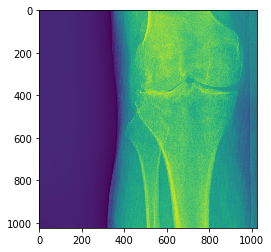

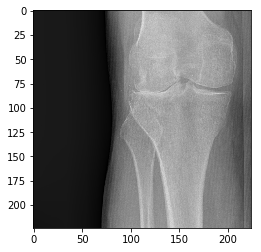

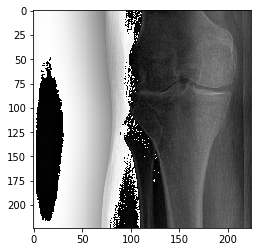

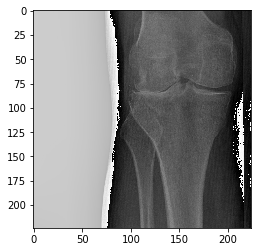

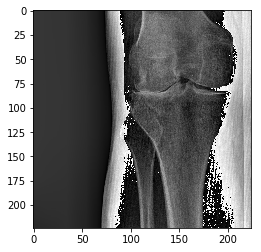

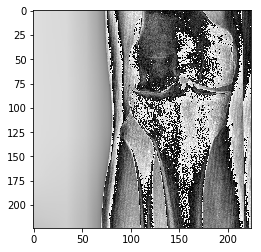

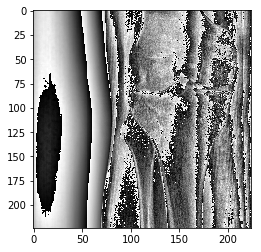

In [134]:
print(train_224_form_1[0][0:1])
print(train_224_form_2_ResNet[0][0:1])
print(train_224_form_2_VGG[0][0:1])
print(train_224_form_2_Xception_Inception[0][0:1])
print(train_224_form_3[0][0:1])
print(train_224_form_4[0][0:1])

plt.figure()
plt.imshow(training_v3[1][0])
plt.figure()
plt.imshow(np.uint8(train_224_form_1[1][0]))
plt.figure()
plt.imshow(np.uint8(train_224_form_2_ResNet[1][0]))
plt.figure()
plt.imshow(np.uint8(train_224_form_2_VGG[1][0]))
plt.figure()
plt.imshow(train_224_form_2_Xception_Inception[1][0])
plt.figure()
plt.imshow(train_224_form_3[1][0])
plt.figure()
plt.imshow(train_224_form_4[1][0])

In [140]:
print('Original:')
print(test_v3[1][3, 100:105, 100:101])
print('Form 1:')
print(test_224_form_1[1][3, 100:105, 100:101,:])
print('Form 2 - ResNet:')
print(test_224_form_2_ResNet[1][3, 100:105, 100:101,:])
print('Form 2 - ResNet old:')
print(test_224_form_2_ResNet_VGG[1][3, 100:105, 100:101,:])
print('Form 2 - VGG:')
print(test_224_form_2_VGG[1][3, 100:105, 100:101,:])
print('Form 2 - Xception-Inception:')
print(test_224_form_2_Xception_Inception[1][3, 100:105, 100:101,:])
print('Form 3:')
print(test_224_form_3[1][3, 100:105, 100:101,:])
print('Form 4:')
print(test_224_form_4[1][3, 100:105, 100:101,:])

Original:
[[ 8.98678398]
 [ 8.61233521]
 [ 8.83700466]
 [ 8.76211452]
 [ 9.73568249]]
Form 1:
[[[ 93.02630819  93.02630819  93.02630819]]

 [[ 92.60792113  92.60792113  92.60792113]]

 [[ 95.16574107  95.16574107  95.16574107]]

 [[ 91.85304387  91.85304387  91.85304387]]

 [[ 90.26650009  90.26650009  90.26650009]]]
Form 2 - ResNet:
[[[-42.84524222 -42.84524222 -42.84524222]]

 [[-42.8284865  -42.8284865  -42.8284865 ]]

 [[-39.79897232 -39.79897232 -39.79897232]]

 [[-42.83695592 -42.83695592 -42.83695592]]

 [[-44.13829441 -44.13829441 -44.13829441]]]
Form 2 - ResNet old:
[[[-42.84524222 -42.84524222 -42.84524222]]

 [[-42.8284865  -42.8284865  -42.8284865 ]]

 [[-39.79897232 -39.79897232 -39.79897232]]

 [[-42.83695592 -42.83695592 -42.83695592]]

 [[-44.13829441 -44.13829441 -44.13829441]]]
Form 2 - VGG:
[[[ 14.69125796  14.69125796  14.69125796]]

 [[ 14.2728709   14.2728709   14.2728709 ]]

 [[ 16.83069084  16.83069084  16.83069084]]

 [[ 13.51799364  13.51799364  13.51799364]]
